In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:

# Load the dataset
df = pd.read_csv(r"C:\Users\Minfy.DESKTOP-81ME0ME\Downloads\inventory_recommendations (1).csv")

In [30]:
df.head()

,Location,Item,Current_Par_Level,Recommended_Par_Level,Reorder_Point,Safety_Stock,Avg_Daily_Demand,Par_Level_Change,Change_Percentage
0,Smith's Bar,Captain Morgan,6199.41,935.245213,512.198300,391.327754,60.435273,-5264.164787,-84.913964
1,Smith's Bar,Yellow Tail,11862.52,1038.333864,568.705814,434.526371,67.089721,-10824.186140,-91.246937
2,Smith's Bar,Grey Goose,7942.75,1065.450430,585.201334,447.987307,68.607014,-6877.299570,-86.585875
3,Smith's Bar,Coors,4319.18,736.008972,435.121012,349.153023,42.983994,-3583.171028,-82.959521
4,Smith's Bar,Jim Beam,8565.93,1023.824726,552.004022,417.198106,67.402958,-7542.105274,-88.047711


In [31]:
df_encoded = df.copy()
le_location = LabelEncoder()
le_item = LabelEncoder()

df_encoded['Location'] = le_location.fit_transform(df['Location'])
df_encoded['Item'] = le_item.fit_transform(df['Item'])

In [32]:
df_encoded.head()

,Location,Item,Current_Par_Level,Recommended_Par_Level,Reorder_Point,Safety_Stock,Avg_Daily_Demand,Par_Level_Change,Change_Percentage
0,3,4,6199.41,935.245213,512.198300,391.327754,60.435273,-5264.164787,-84.913964
1,3,15,11862.52,1038.333864,568.705814,434.526371,67.089721,-10824.186140,-91.246937
2,3,6,7942.75,1065.450430,585.201334,447.987307,68.607014,-6877.299570,-86.585875
3,3,5,4319.18,736.008972,435.121012,349.153023,42.983994,-3583.171028,-82.959521
4,3,10,8565.93,1023.824726,552.004022,417.198106,67.402958,-7542.105274,-88.047711


In [33]:
features = ['Location', 'Item', 'Current_Par_Level', 'Reorder_Point', 'Safety_Stock']
target = 'Avg_Daily_Demand'

X = df_encoded[features]
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [35]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Fixed
r2 = r2_score(y_test, y_pred)
print(f"Model RMSE: {rmse:.2f}")
print(f"Model R²: {r2:.2f}")

Model RMSE: 2.98
Model R²: 0.95


In [36]:
df_encoded['Predicted_Demand'] = model.predict(X)


In [37]:
LEAD_TIME = 7  # days
Z_SCORE = 1.65  # for ~95% service level
SIMULATED_STD_DEV = df_encoded['Predicted_Demand'].std()

df_encoded['Recommended_Par_Level_Model'] = (
    df_encoded['Predicted_Demand'] * LEAD_TIME +
    Z_SCORE * SIMULATED_STD_DEV * np.sqrt(LEAD_TIME)
).round(2)

In [38]:
np.random.seed(42)

In [39]:
def simulate_stock(item_row, days=30):
    inventory = item_row['Recommended_Par_Level_Model']
    reorder_point = item_row['Predicted_Demand'] * LEAD_TIME * 0.5
    daily_sales = np.random.normal(loc=item_row['Predicted_Demand'], scale=SIMULATED_STD_DEV*0.1, size=days)
    stockouts = 0
    overstock_days = 0
    history = []

    for demand in daily_sales:
        demand = max(demand, 0)
        if inventory < demand:
            stockouts += 1
        inventory -= demand
        if inventory < reorder_point:
            inventory += item_row['Recommended_Par_Level_Model']  # simulate reorder
        if inventory > item_row['Recommended_Par_Level_Model']:
            overstock_days += 1
        history.append(inventory)

    return stockouts, overstock_days, history

df_encoded[['Stockouts', 'OverstockDays', 'InventoryHistory']] = df_encoded.apply(
    lambda row: pd.Series(simulate_stock(row)), axis=1
)

In [40]:
from sklearn.metrics import mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f" Evaluation Metrics:")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f"MAE  (Mean Absolute Error)     : {mae:.2f}")
print(f"R²   (R-squared Score)         : {r2:.2%}")

 Evaluation Metrics:
RMSE (Root Mean Squared Error): 2.98
MAE  (Mean Absolute Error)     : 2.27
R²   (R-squared Score)         : 95.49%


In [41]:
print("\nSimulation Summary:")
print(df_encoded[['Location', 'Item', 'Predicted_Demand', 'Recommended_Par_Level_Model', 'Stockouts', 'OverstockDays']])



Simulation Summary:
    Location  Item  Predicted_Demand  Recommended_Par_Level_Model  Stockouts  \
0          3     4         59.016175                       463.18          0   
1          3    15         66.665846                       516.73          0   
2          3     6         71.160129                       548.19          0   
3          3     5         42.701804                       348.98          0   
4          3    10         65.781214                       510.53          0   
..       ...   ...               ...                          ...        ...   
91         5     9         42.408552                       346.92          0   
92         5    13         58.812650                       461.75          0   
93         5     3         44.334417                       360.41          0   
94         5     7         38.493104                       319.52          0   
95         5     2         58.566452                       460.03          0   

    OverstockDays 

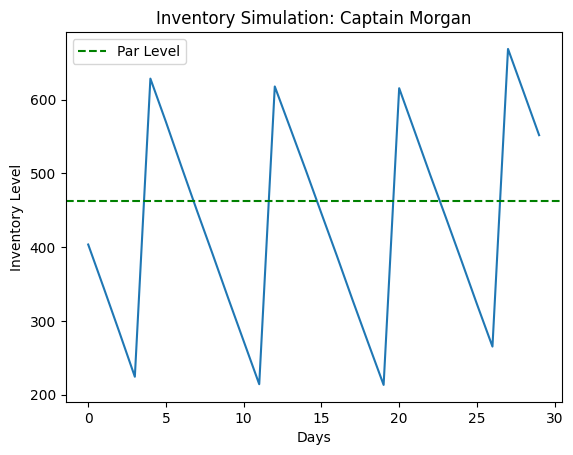

In [42]:
sample = df_encoded.iloc[0]
plt.plot(sample['InventoryHistory'])
plt.title(f"Inventory Simulation: {le_item.inverse_transform([int(sample['Item'])])[0]}")
plt.xlabel("Days")
plt.ylabel("Inventory Level")
plt.axhline(sample['Recommended_Par_Level_Model'], color='green', linestyle='--', label='Par Level')
plt.legend()
plt.show()